## MINERANDO DADOS

In [50]:
import os
import scipy.stats as stats
from scipy.stats import t, norm, probplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, ceil

microdados = pd.read_excel('microdados.xlsx')

microdados.head()

,NU_ANO,CO_UF_ESCOLA,SG_UF_ESCOLA,CO_MUNICIPIO_ESCOLA,NO_MUNICIPIO_ESCOLA,CO_ESCOLA_EDUCACENSO,NO_ESCOLA_EDUCACENSO,TP_DEPENDENCIA_ADM_ESCOLA,TP_LOCALIZACAO_ESCOLA,NU_MATRICULAS,...,NU_MEDIA_RED,NU_MEDIA_OBJ,NU_MEDIA_TOT,INSE,PC_FORMACAO_DOCENTE,NU_TAXA_PERMANENCIA,NU_TAXA_APROVACAO,NU_TAXA_REPROVACAO,NU_TAXA_ABANDONO,PORTE_ESCOLA
0,2007,11,RO,1100205,Porto Velho,11000058,CENTRO DE ENSINO CLASSE A,4,1,144,...,NaN,NaN,69.03,NaN,NaN,NaN,91.9,8.1,0.0,Maior que 90 alunos
1,2006,11,RO,1100205,Porto Velho,11000058,CENTRO DE ENSINO CLASSE A,4,1,184,...,NaN,NaN,57.82,NaN,NaN,NaN,NaN,NaN,NaN,Maior que 90 alunos
2,2005,11,RO,1100205,Porto Velho,11000058,CENTRO DE ENSINO CLASSE A,4,1,220,...,NaN,NaN,64.83,NaN,NaN,NaN,86.5,12.4,1.1,Maior que 90 alunos
3,2008,11,RO,1100205,Porto Velho,11000058,CENTRO DE ENSINO CLASSE A,4,1,186,...,72.16,60.02,NaN,NaN,NaN,NaN,90.3,9.7,0.0,Maior que 90 alunos
4,2007,11,RO,1100205,Porto Velho,11000171,CENTRO EDUCACIONAL MOJUCA,4,1,19,...,NaN,NaN,58.84,NaN,NaN,NaN,74.2,21.0,4.8,De 1 a 30 alunos


# Mineração & Limpeza da Base de Dados

In [51]:
dados = microdados.loc[:,['NU_MEDIA_TOT','NU_ANO', 'SG_UF_ESCOLA','TP_LOCALIZACAO_ESCOLA','PORTE_ESCOLA','NU_TAXA_APROVACAO']]

In [52]:
# Renomeando as colunas para facilitar as análises e entendimento das colunas respectivas

dados.rename(columns={'NU_MEDIA_TOT':'MEDIA_TOTAL_ENEM'}, inplace=True)
dados.rename(columns={'NU_ANO':'ANO'}, inplace=True)
dados.rename(columns={'SG_UF_ESCOLA':'UF_ESCOLA'}, inplace=True)
dados.rename(columns={'TP_LOCALIZACAO_ESCOLA':'LOCAL'}, inplace=True)
dados.rename(columns={'PORTE_ESCOLA':'TAMANHO'}, inplace=True)
dados.rename(columns={'NU_TAXA_APROVACAO':'TAXA_APROVACAO'}, inplace=True)

In [53]:
# Adequando cada coluna com seus tipos de dados

dados['TAMANHO'] = dados['TAMANHO'].astype('category')
dados['UF_ESCOLA'] = dados['UF_ESCOLA'].astype('category')
dados['LOCAL'] = dados['LOCAL'].astype('category')


dados['LOCAL'] = dados['LOCAL'].cat.rename_categories(['Urbano', 'Rural'])


dados = dados.dropna(axis=0, how='any')
dados.head(70)

MEDIA_TOTAL_ENEM   ANO UF_ESCOLA   LOCAL              TAMANHO  \
0               69.03  2007        RO  Urbano  Maior que 90 alunos   
2               64.83  2005        RO  Urbano  Maior que 90 alunos   
4               58.84  2007        RO  Urbano     De 1 a 30 alunos   
6               35.44  2005        RO  Urbano     De 1 a 30 alunos   
7               48.46  2005        RO  Urbano    De 61 a 90 alunos   
..                ...   ...       ...     ...                  ...   
137             46.66  2007        RO  Urbano    De 61 a 90 alunos   
140             45.79  2007        RO   Rural    De 31 a 60 alunos   
142             38.22  2005        RO  Urbano    De 61 a 90 alunos   
144             42.66  2007        RO  Urbano  Maior que 90 alunos   
145             39.45  2005        RO  Urbano    De 61 a 90 alunos   

     TAXA_APROVACAO  
0              91.9  
2              86.5  
4              74.2  
6              69.3  
7              86.5  
..              ...  
137            68.9  
140            80.5  
142            78.2  
144            76.2  
145            87.7  

[70 rows x 6 columns]

# Análise Exploratória 

## 1. Média Enem X Ano de Aplicação

In [54]:
# Análise de target quantitativa e feature quantidade

print(f'Correlação entre média total no ENEM e ano de aplicação: {dados.ANO.corr(dados.MEDIA_TOTAL_ENEM)}')
print(f'Correlação entre média total no ENEM e taxa de aprovação no Ensino Médio: {dados.TAXA_APROVACAO.corr(dados.MEDIA_TOTAL_ENEM)}')

Correlação entre média total no ENEM e ano de aplicação: 0.361921333480833
Correlação entre média total no ENEM e taxa de aprovação no Ensino Médio: 0.47909482648601454


## 2. Média Enem X Taxa Aprovação no Ensino Médio

In [55]:
#Separando os estados brasileiros de acordo com sua região no país para facilitar análise por histogramas

# Dicionário de estado por região para facilitar a divisão
regioes = {
    'Norte': ['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['DF', 'GO', 'MS', 'MT'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']}

# Percorrendo as regiões e criando nova coluna no dataframe com a região específica de cada estado
for regiao, estados in regioes.items():
    dados.loc[dados['UF_ESCOLA'].isin(estados), 'REGIAO'] = regiao
    
dados.head()

,MEDIA_TOTAL_ENEM,ANO,UF_ESCOLA,LOCAL,TAMANHO,TAXA_APROVACAO,REGIAO
0,69.03,2007,RO,Urbano,Maior que 90 alunos,91.9,Norte
2,64.83,2005,RO,Urbano,Maior que 90 alunos,86.5,Norte
4,58.84,2007,RO,Urbano,De 1 a 30 alunos,74.2,Norte
6,35.44,2005,RO,Urbano,De 1 a 30 alunos,69.3,Norte
7,48.46,2005,RO,Urbano,De 61 a 90 alunos,86.5,Norte


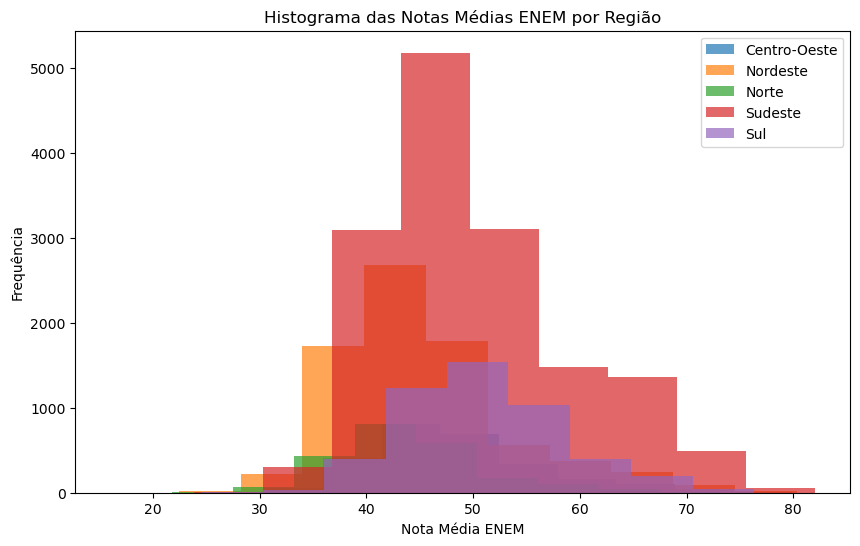

In [56]:
regiao_nota = dados.groupby('REGIAO')['MEDIA_TOTAL_ENEM']

plt.figure(figsize=(10, 6))
plt.xlabel('Nota Média ENEM')
regiao_nota.plot(kind='hist', alpha=0.7, legend=True, density = True) 
plt.title('Histograma das Notas Médias ENEM por Região')
plt.ylabel('Frequência Relativa (Densidade)');

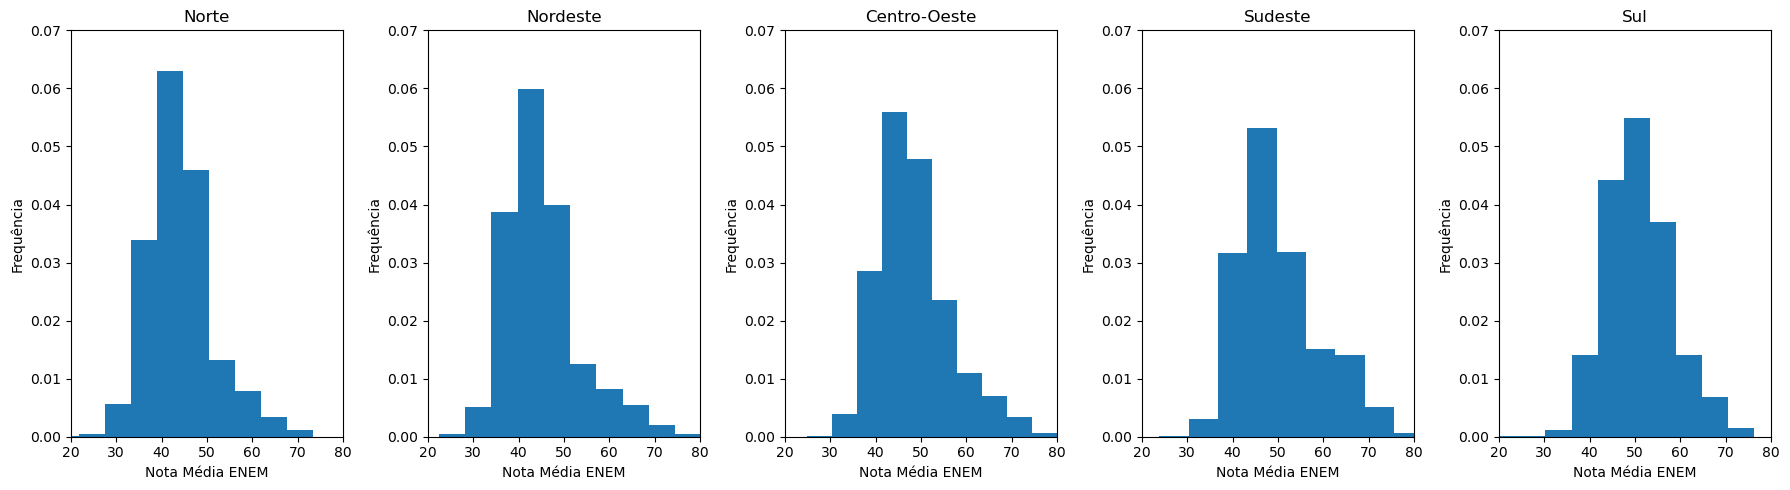

In [57]:
# Separado em um histograma por região
dados_norte = dados.loc[dados.REGIAO=='Norte', :]
dados_nordeste = dados.loc[dados.REGIAO=='Nordeste', :]
dados_centro_oeste = dados.loc[dados.REGIAO=='Centro-Oeste', :]
dados_sudeste = dados.loc[dados.REGIAO=='Sudeste', :]
dados_sul = dados.loc[dados.REGIAO=='Sul', :]

plt.figure(figsize=(18,5)) 

plt.subplot(1,5,1)
plt.title('Norte')
plt.xlabel('Nota Média ENEM')
plt.ylabel('Frequência')
plt.xlim(20,80)
plt.ylim(0,0.07)
plt.hist(dados_norte.MEDIA_TOTAL_ENEM, density = True, edgecolor = 'white')

plt.subplot(1,5,2)
plt.title('Nordeste')
plt.xlabel('Nota Média ENEM')
plt.ylabel('Frequência')
plt.xlim(20,80)
plt.ylim(0,0.07)
plt.hist(dados_nordeste.MEDIA_TOTAL_ENEM, density = True, edgecolor = 'white')

plt.subplot(1,5,3)
plt.title('Centro-Oeste')
plt.xlabel('Nota Média ENEM')
plt.ylabel('Frequência')
plt.xlim(20,80)
plt.ylim(0,0.07)
plt.hist(dados_centro_oeste.MEDIA_TOTAL_ENEM, density = True, edgecolor = 'white')

plt.subplot(1,5,4)
plt.title('Sudeste')
plt.xlabel('Nota Média ENEM')
plt.ylabel('Frequência')
plt.xlim(20,80)
plt.ylim(0,0.07)
plt.hist(dados_sudeste.MEDIA_TOTAL_ENEM, density = True, edgecolor = 'white')

plt.subplot(1,5,5)
plt.title('Sul')
plt.xlabel('Nota Média ENEM')
plt.ylabel('Frequência')
plt.xlim(20,80)
plt.ylim(0,0.07)
plt.hist(dados_sul.MEDIA_TOTAL_ENEM, density = True, edgecolor = 'white')


plt.tight_layout();

Text(0, 0.5, 'Densidade')

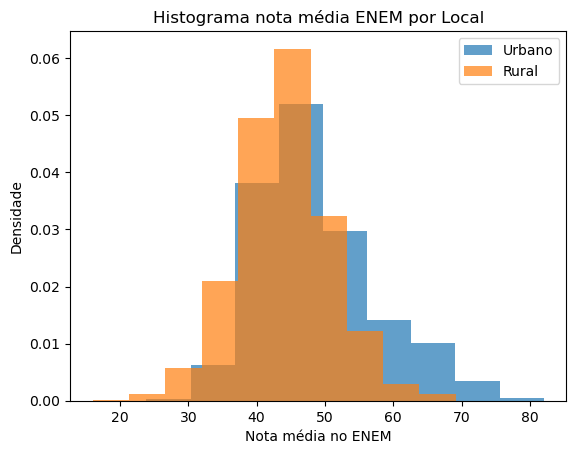

In [58]:
local_nota = dados.groupby('LOCAL')['MEDIA_TOTAL_ENEM']

local_nota.plot(kind='hist', alpha=0.7, legend=True, density=True) # Com densidade

plt.title('Histograma nota média ENEM por Local')
plt.xlabel('Nota média no ENEM')
plt.ylabel('Densidade')

Text(0, 0.5, 'Densidade')

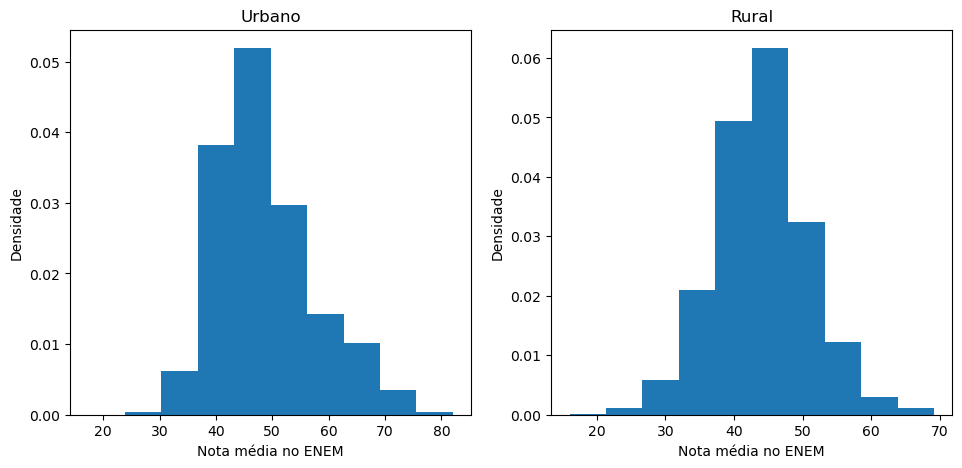

In [59]:
dados_urbano = dados.loc[dados['LOCAL'] == 'Urbano']
dados_rural = dados.loc[dados['LOCAL'] == 'Rural']


plt.figure(figsize=(30,5)) 
plt.subplot(1,5,1)
plt.hist(dados_urbano['MEDIA_TOTAL_ENEM'], density = True)

plt.title('Urbano')
plt.xlabel('Nota média no ENEM')
plt.ylabel('Densidade')


plt.subplot(1,5,2)
plt.hist(dados_rural['MEDIA_TOTAL_ENEM'], density = True)

plt.title('Rural')
plt.xlabel('Nota média no ENEM')
plt.ylabel('Densidade')


Text(0, 0.5, 'Densidade')

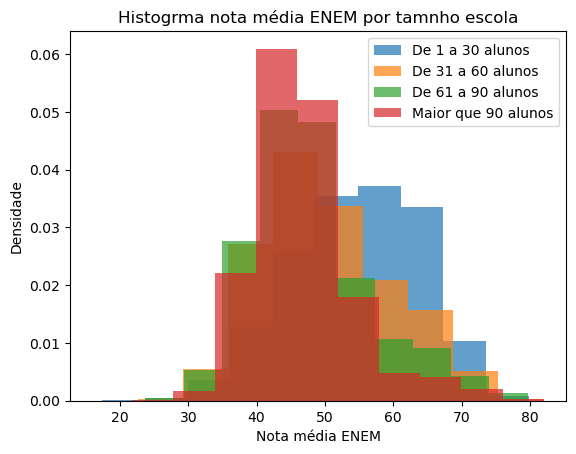

In [62]:
tamanho = dados.groupby('TAMANHO')['MEDIA_TOTAL_ENEM']


tamanho.plot(kind='hist', alpha=0.7, legend=True, density=True)
plt.title('Histogrma nota média ENEM por tamnho escola')
plt.xlabel('Nota média ENEM')
plt.ylabel('Densidade')

Text(0, 0.5, 'Densidade')

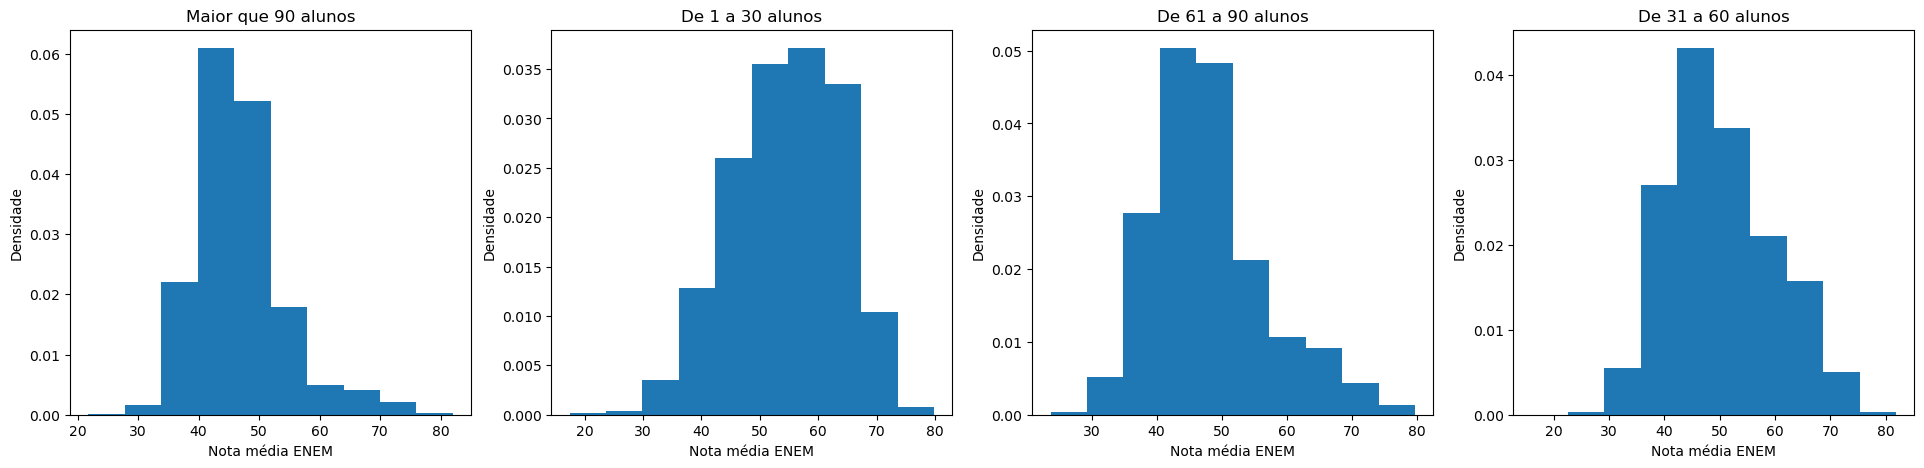

In [63]:
dados_90 = dados.loc[dados['TAMANHO'] == 'Maior que 90 alunos']
dados_1_30 = dados.loc[dados['TAMANHO'] == 'De 1 a 30 alunos']
dados_61_90 = dados.loc[dados['TAMANHO'] == 'De 61 a 90 alunos']
dados_31_60 = dados.loc[dados['TAMANHO'] == 'De 31 a 60 alunos']

plt.figure(figsize=(30,5))

plt.subplot(1,5,2)
plt.hist(dados_1_30['MEDIA_TOTAL_ENEM'], density=True)
plt.title('De 1 a 30 alunos')
plt.xlabel('Nota média ENEM')
plt.ylabel('Densidade')

plt.subplot(1,5,4)
plt.hist(dados_31_60['MEDIA_TOTAL_ENEM'], density=True)
plt.title('De 31 a 60 alunos')
plt.xlabel('Nota média ENEM')
plt.ylabel('Densidade')


plt.subplot(1,5,3)
plt.hist(dados_61_90['MEDIA_TOTAL_ENEM'], density=True)
plt.title('De 61 a 90 alunos')
plt.xlabel('Nota média ENEM')
plt.ylabel('Densidade')

plt.subplot(1,5,1)
plt.hist(dados_90['MEDIA_TOTAL_ENEM'], density=True)
plt.title('Maior que 90 alunos')
plt.xlabel('Nota média ENEM')
plt.ylabel('Densidade')

